In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Spatial subsets and averages

Finch includes processes to subset and average gridded data. Subsetting processes return a rectangular portion of the original grid. This portion can either be defined as a bounding box over geographic coordinates (longitude, latitude), or as a polygon outline. 

When subsetting a polygon or over a curvilinear grid, the subset usually does not align with the grid dimensions. In this case, the subset functions will return data over a rectangular array, but mask grid cells that fall outside the subset. 

In [2]:
import os
import xarray as xr
from birdy import WPSClient

In [3]:
pavics_url = 'https://pavics.ouranos.ca/twitcher/ows/proxy/finch/wps'
url = os.environ.get('WPS_URL', 'http://localhost:5000') #pavics_url)
verify_ssl = True if 'DISABLE_VERIFY_SSL' not in os.environ else False
wps = WPSClient(url, verify=verify_ssl)

For the examples in this notebook, we are using a year of daily data, minimum temperature over southern Québec.

In [4]:
# URL to a netCDF of minimum daily temperature over southern Quebec
tasmin_url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/testdata/xclim/NRCANdaily/nrcan_canada_daily_tasmin_1990.nc"

## Bounding box subsetting

The `subset_bbox` process returns the grid portion within longitude and latitude bounds. Western hemisphere longitudes can be given as negative numbers or positive ones, no matter what range the dataset uses (longitudes are either in `[-180, 180[`  or `[0, 360[`).

The box chosen here is over the city of Montréal and its surroundings.

In [5]:
resp = wps.subset_bbox(tasmin_url, lon0=-74.2, lon1=-73.3, lat0=45.25, lat1=45.80, variable=['tasmin'],
                       start_date='1990-01-01', end_date='1990-01-08')

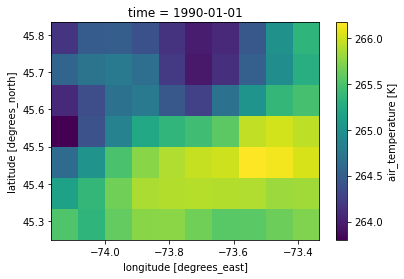

In [6]:
ds_mtl = resp.get(asobj=True).output
ds_mtl.tasmin.isel(time=0).plot();

## Polygon subsetting

The subset processes of finch also support subsetting from a polygon input. Polygons are passed as GeoJSON or zipped-ShapeFiles files. They can be either local or remote.

In the next example, we retrieve a dataset of polygons from a geospatial data server. Communication with this server uses the Web Feature Services (WFS) standard, an Open Geospatial Consortium (OGC) protocol. 

We then inspect and select the polygon using GeoPandas, write it down in a local file and send the subsetting request to finch.

The subsetting methods are provided under-the-hood by `clisops`. Note that the grid cells returned are those whose centroid lies within the polygon. If the polygon overlays a corner of a grid cell, it will not be included in the subset, or will be masked. Thus, this algorithm might not be appropriate for small or intricate polygons relative to the underlying grid.

In [7]:
from owslib.wfs import WebFeatureService
import json
import geopandas as gpd
from pathlib import Path

# Connect to GeoServer WFS service.
wfs_url = 'https://pavics.ouranos.ca/geoserver/wfs'  # TEST_USE_PROD_DATA
wfs = WebFeatureService(wfs_url, version='1.1.0')

### Downloading and handling polygons locally

This first example shows how to download a collection of polygons from the GeoServer using WFS and `owslib`. The polygon selection is done with `geopandas`, locally, allowing for more polygon processing if needed.

In [8]:
# Get the json as a binary stream
# Here we select Quebec's MRCs polygons
# We select only a few properties to be returned.
data = wfs.getfeature(
    typename='public:quebec_admin_boundaries',
    #bbox=(-93.1, 41.1, -75.0, 49.6),
    outputFormat='json',
    propertyname=['the_geom', 'RES_NM_REG']
)
# Load into a GeoDataFrame by reading the json on-the-fly
all_shapes = gpd.GeoDataFrame.from_features(json.load(data))
all_shapes

,geometry,RES_NM_REG
0,"MULTIPOLYGON (((-63.55940 54.98840, -63.56340 ...",Côte-Nord
1,"MULTIPOLYGON (((-73.88440 45.54370, -73.88480 ...",Laval
2,"MULTIPOLYGON (((-75.04050 47.76270, -75.02440 ...",Laurentides
3,"MULTIPOLYGON (((-72.96110 46.09000, -72.95640 ...",Montérégie
4,"MULTIPOLYGON (((-75.98530 47.77010, -75.98530 ...",Abitibi-Témiscamingue
5,"MULTIPOLYGON (((-71.06890 45.92750, -71.06890 ...",Estrie
6,"MULTIPOLYGON (((-75.52060 47.84720, -75.52070 ...",Outaouais
7,"MULTIPOLYGON (((-74.67630 48.99960, -74.62850 ...",Mauricie
8,"MULTIPOLYGON (((-63.52630 48.92920, -63.49910 ...",Gaspésie--Îles-de-la-Madeleine
9,"MULTIPOLYGON (((-70.02990 52.83260, -70.02570 ...",Saguenay--Lac-Saint-Jean


In [9]:
# Select 3 regions around the city of Montréal
poly_mtl = all_shapes[all_shapes.RES_NM_REG.isin(['Montérégie', 'Montréal', 'Laval'])]
poly_mtl

,geometry,RES_NM_REG
1,"MULTIPOLYGON (((-73.88440 45.54370, -73.88480 ...",Laval
3,"MULTIPOLYGON (((-72.96110 46.09000, -72.95640 ...",Montérégie
16,"MULTIPOLYGON (((-73.70930 45.54320, -73.70870 ...",Montréal


In [10]:
# Write to file
from tempfile import TemporaryDirectory
tmp_dir = TemporaryDirectory()
poly_file = Path(tmp_dir.name) / 'mtl_raw.geojson'
poly_mtl.to_file(poly_file, driver='GeoJSON')

Now that we have a (multipart) polygon, we can call the WPS subset process. When passing a local file, birdy requires the path to be absolute, our use of a `Path` object makes this easy. Before subsetting, the three polygons of our GeoJSON will be merged as one.

In [11]:
resp = wps.subset_polygon(tasmin_url, poly_file.absolute(), variable=['tasmin'],
                          start_date='1990-01-01', end_date='1990-01-08')

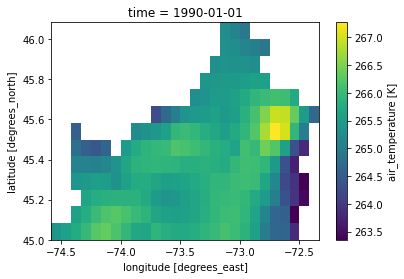

In [12]:
ds_mtl = resp.get(asobj=True).output
ds_mtl.tasmin.isel(time=0).plot();

## Averaging over polygons

Finch also provides an `average_subset` process. The call is similar, but it instead averages the data over each polygon in the GeoJSON. In this case, in opposition to `subset_shape`, the intersection between polygon and grid cells is exact: partial overlaps between the polygon and grid cell outline are considered, as well as holes within the polygon itself. 

The computation of these overlaps can be time-consuming, especially when the polygon is defined at high resolution. In turn, long execution time can cause time-outs on the server side. As the second example below demonstrates, a strategy to speed up execution is to simplify the polygon shape. 


### Basic averaging

In [13]:
# Basic example, let's simply reuse the same geojson:
resp = wps.average_polygon(tasmin_url, poly_file.absolute(), variable=['tasmin'],
                           start_date='1990-01-01', end_date='1990-01-08')

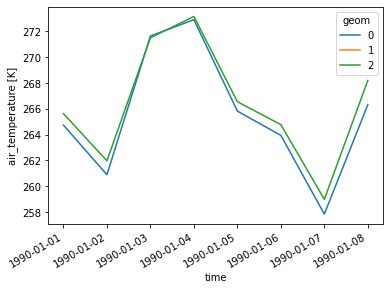

In [14]:
ds_avgmtl = resp.get(asobj=True).output
ds_avgmtl.tasmin.plot(hue='geom');

In [15]:
ds_avgmtl

<xarray.Dataset>
Dimensions:     (time: 8, geom: 3)
Coordinates:
  * time        (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-01-08
    lon         (geom) float64 ...
    lat         (geom) float64 ...
  * geom        (geom) int64 0 1 2
    RES_NM_REG  (geom) object ...
Data variables:
    tasmin      (time, geom) float32 ...
Attributes:
    Conventions:     CF-1.5
    title:           NRCAN 10km Gridded Climate Dataset
    history:         2012-10-22T15:44:58: Convert from original format to NetCDF
    institution:     NRCAN
    source:          ANUSPLIN
    redistribution:  Redistribution policy unknown. For internal use only.
    regrid_method:   conservative

### High-resolution polygons

The pavics finch server limits the uploads to 3 MB, so our polygon file is limited to that size. In any case, a 3 MB polygon is already quite large and will take a long time to process. Here, we download another polygon (the whole Québec province) and simplify it _before_ sending it to finch.

In [16]:
# Get polygon dataset from GeoServer
data = wfs.getfeature(
    typename='public:canada_admin_boundaries',
    # This bbox represents our input data's coverage.
    # Only polygons touching that zone will be returned in the response.
    bbox=(-74.5, 45.2, -73, 46),
    outputFormat='JSON'
)
# Directly read into a GeoDataFrame
all_shapes = gpd.GeoDataFrame.from_features(json.load(data))
all_shapes

,geometry,PRUID,PRNAME,PRENAME,PRFNAME,PREABBR,PRFABBR
0,"MULTIPOLYGON (((-74.63810 44.99980, -74.63860 ...",24,Quebec / Qubec,Quebec,Qubec,Que.,Qc
1,"MULTIPOLYGON (((-82.68870 41.68450, -82.68630 ...",35,Ontario,Ontario,Ontario,Ont.,Ont.


In [17]:
# Create a Dataframe with simplified polygons.
# The buffer(0) call repairs polygons that might have been broken by the simplification.
poly_simple = all_shapes.copy()
poly_simple['geometry'] = all_shapes.simplify(tolerance=0.01, preserve_topology=True).buffer(0)

In [18]:
# Write polygons to geojson files.
poly_file = Path(tmp_dir.name) / 'prov_simp.geojson'
poly_simple.to_file(poly_file, driver='GeoJSON')

# Write the unsimplfied version for comparison only
#all_shapes.to_file(Path(tmp_dir.name) / 'prov_raw.geojson', driver='GeoJSON')

The simplified version is way smaller than the raw. Finch will not accept inputs larger than 3 Mo (raises "BrokenPipe" error). But even with ~2 Mo, the process is to slow and might time out.

In [19]:
for file in Path(tmp_dir.name).iterdir():
    print(f"{file.name:20s} {file.stat().st_size / 2**10:.0f} KB")

prov_simp.geojson    793 KB
mtl_raw.geojson      95 KB


In [20]:
resp = wps.average_polygon(
    resource=tasmin_url, 
    shape=poly_file.absolute(),
    start_date='1990-01-01',
    end_date='1990-01-08',
    tolerance=-1,  # deactivate finch's tolerance, since we already simplified the shape
)

In [21]:
avg = resp.get(asobj=True).output
avg

<xarray.Dataset>
Dimensions:       (time: 8, geom: 2, ts: 3)
Coordinates:
  * ts            (ts) float32 nan nan nan
  * time          (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-01-08
    lon           (geom) float64 ...
    lat           (geom) float64 ...
  * geom          (geom) int64 0 1
    PRUID         (geom) object ...
    PRNAME        (geom) object ...
    PRENAME       (geom) object ...
    PRFNAME       (geom) object ...
    PREABBR       (geom) object ...
    PRFABBR       (geom) object ...
Data variables:
    tasmin        (time, geom) float32 ...
    time_vectors  (time, ts, geom) float64 ...
Attributes:
    Conventions:     CF-1.5
    title:           NRCAN 10km Gridded Climate Dataset
    history:         2012-10-22T15:44:58: Convert from original format to NetCDF
    institution:     NRCAN
    source:          ANUSPLIN
    redistribution:  Redistribution policy unknown. For internal use only.
    regrid_method:   conservative

In [22]:
tmp_dir.cleanup()
del tmp_dir